# Real-Time Conference Registration Forecasting System

This notebook provides real-time forecasting of conference registrations based on current registration data and historical patterns.

**Key Features:**
- Uses current registration data to predict future registrations until event date
- Provides confidence intervals (low/high estimates)
- Matches historical patterns based on target audience
- Real-time updates with fresh data
- Comprehensive risk assessment and insights

In [1]:
# Install and import required libraries
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Failed to install {package}")

# Required packages
required_packages = ["pandas", "numpy", "matplotlib", "scipy", "scikit-learn"]

print("Checking and installing dependencies...")
for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

print("\nDependency check complete!")

Checking and installing dependencies...
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ scipy already installed
Installing scikit-learn...
✓ Successfully installed scikit-learn

Dependency check complete!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Tuple, Optional
import re

warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
# =============================================================================
# USER INPUT INTERFACE
# =============================================================================

def get_user_inputs():
    """
    Get user inputs for forecasting parameters.
    In a real implementation, this could be a web form or GUI.
    """
    print("=" * 60)
    print("REAL-TIME CONFERENCE REGISTRATION FORECASTING")
    print("=" * 60)
    
    # Target audience selection
    print("\nAvailable Target Audiences:")
    audiences = [
        "Education Managers",
        "Education property managers", 
        "IT MANAGER",
        "Property Managers"
    ]
    
    for i, audience in enumerate(audiences, 1):
        print(f"{i}. {audience}")
    print(f"{len(audiences) + 1}. None of the above (use all historical data)")
    
    # For demo purposes, we'll use predefined values
    # In real implementation, these would be user inputs
    selected_audience_idx = 2  # Change this to test different audiences
    event_date = "15/08/2025"  # Event date (DD/MM/YYYY)
    marketing_start_date = "01/07/2025"  # Marketing start date (DD/MM/YYYY)
    
    print(f"\n[DEMO] Selected audience: {selected_audience_idx}")
    print(f"[DEMO] Event date: {event_date}")
    print(f"[DEMO] Marketing start date: {marketing_start_date}")
    
    # Process selection
    if selected_audience_idx <= len(audiences):
        target_audience = audiences[selected_audience_idx - 1]
        use_all_data = False
    else:
        target_audience = "All Audiences"
        use_all_data = True
    
    return {
        'target_audience': target_audience,
        'use_all_data': use_all_data,
        'event_date': event_date,
        'marketing_start_date': marketing_start_date,
        'current_date': datetime.now().strftime("%d/%m/%Y")
    }

# Get user inputs
user_config = get_user_inputs()
print(f"\nConfiguration loaded: {user_config}")

REAL-TIME CONFERENCE REGISTRATION FORECASTING

Available Target Audiences:
1. Education Managers
2. Education property managers
3. IT MANAGER
4. Property Managers
5. None of the above (use all historical data)

[DEMO] Selected audience: 2
[DEMO] Event date: 15/08/2025
[DEMO] Marketing start date: 01/07/2025

Configuration loaded: {'target_audience': 'Education property managers', 'use_all_data': False, 'event_date': '15/08/2025', 'marketing_start_date': '01/07/2025', 'current_date': '20/07/2025'}


In [4]:
# =============================================================================
# DATA LOADING AND PROCESSING 
# =============================================================================

def parse_date(date_str: str) -> datetime:
    """Parse date string in DD/MM/YYYY format"""
    try:
        return datetime.strptime(date_str.strip(), "%d/%m/%Y")
    except ValueError:
        try:
            return datetime.strptime(date_str.strip(), "%Y-%m-%d")
        except ValueError:
            print(f"Warning: Could not parse date '{date_str}'")
            return None

def load_current_registrations() -> pd.DataFrame:
    """
    Load current registration data from sample_data.csv
    """
    try:
        df = pd.read_csv('sample_data.csv')
        df['CreatedDate'] = df['Created Date'].apply(parse_date)
        df = df.dropna(subset=['CreatedDate'])
        print(f"✓ Loaded {len(df)} current registrations from sample_data.csv")
        return df
    except Exception as e:
        print(f"✗ Error loading current registrations: {e}")
        return pd.DataFrame()

def load_historical_patterns(target_audience: str, use_all_data: bool) -> Dict:
    """
    Load historical patterns from ONLY Cleaned_Dataset.csv files.
    Completely ignores SourceFile column and other CSV files.
    """
    base_path = "CONF. DATASET"
    
    if not os.path.exists(base_path):
        return {'error': f'Dataset directory "{base_path}" not found'}
    
    # Define audience folder mapping
    audience_folders = {
        "Education Managers": "Education Managers",
        "Education property managers": "Education property managers", 
        "IT MANAGER": "IT MANAGER",
        "Property Managers": "Property Managers"
    }
    
    events = []
    
    if use_all_data:
        # Load from all audience folders
        folders_to_check = list(audience_folders.values())
    else:
        # Load only from target audience folder
        if target_audience in audience_folders:
            folders_to_check = [audience_folders[target_audience]]
        else:
            return {'error': f'Unknown target audience: {target_audience}'}
    
    for folder in folders_to_check:
        folder_path = os.path.join(base_path, folder)
        
        if not os.path.exists(folder_path):
            print(f"Warning: Folder '{folder}' not found, skipping...")
            continue
        
        # ONLY load Cleaned_Dataset.csv - ignore all other CSV files
        cleaned_file = os.path.join(folder_path, "Cleaned_Dataset.csv")
        
        if not os.path.exists(cleaned_file):
            print(f"Warning: No Cleaned_Dataset.csv found in '{folder}', skipping...")
            continue
        
        try:
            # Load the cleaned dataset
            df = pd.read_csv(cleaned_file)
            
            # COMPLETELY IGNORE SourceFile column - drop it if it exists
            if 'SourceFile' in df.columns:
                df = df.drop('SourceFile', axis=1)
            
            # Process the data (focusing only on registration patterns)
            if 'CreatedDate' in df.columns:
                df['CreatedDate'] = df['CreatedDate'].apply(parse_date)
                df = df.dropna(subset=['CreatedDate'])
                
                if len(df) > 0:
                    # Calculate registration timeline
                    df = df.sort_values('CreatedDate')
                    start_date = df['CreatedDate'].min()
                    end_date = df['CreatedDate'].max()
                    
                    # Calculate weeks since start for each registration
                    df['WeeksSinceStart'] = (df['CreatedDate'] - start_date).dt.days // 7
                    
                    # Group by weeks
                    weekly_counts = df.groupby('WeeksSinceStart').size().reset_index()
                    weekly_counts.columns = ['Week', 'Registrations']
                    
                    # Fill missing weeks with 0
                    if len(weekly_counts) > 0:
                        max_week = weekly_counts['Week'].max()
                        all_weeks = pd.DataFrame({'Week': range(0, max_week + 1)})
                        weekly_counts = all_weeks.merge(weekly_counts, on='Week', how='left').fillna(0)
                    
                    weekly_counts['CumulativeRegistrations'] = weekly_counts['Registrations'].cumsum()
                    
                    # Create event record (pattern-focused, no file references)
                    event_data = {
                        'audience': folder,
                        'total_registrations': len(df),
                        'duration_weeks': int(weekly_counts['Week'].max()) if len(weekly_counts) > 0 else 0,
                        'weekly_data': weekly_counts,
                        'date_range': f"{start_date.strftime('%d/%m/%Y')} to {end_date.strftime('%d/%m/%Y')}"
                    }
                    
                    events.append(event_data)
                    print(f"✓ Loaded pattern from {folder}: {len(df)} registrations over {event_data['duration_weeks']} weeks")
                
        except Exception as e:
            print(f"✗ Error loading {cleaned_file}: {e}")
            continue
    
    if len(events) == 0:
        return {'error': 'No valid historical patterns found in cleaned datasets'}
    
    return {
        'events': events,
        'total_events': len(events),
        'audiences_covered': list(set([e['audience'] for e in events]))
    }

def calculate_date_info(event_date: str, marketing_start_date: str, current_date: str) -> Dict:
    """
    Calculate date-related information for forecasting
    """
    try:
        event_dt = parse_date(event_date)
        marketing_start_dt = parse_date(marketing_start_date)
        current_dt = parse_date(current_date)
        
        if None in [event_dt, marketing_start_dt, current_dt]:
            return {'error': 'Invalid date format. Use DD/MM/YYYY'}
        
        total_days = (event_dt - marketing_start_dt).days
        elapsed_days = (current_dt - marketing_start_dt).days
        remaining_days = (event_dt - current_dt).days
        
        weeks_elapsed = elapsed_days // 7
        weeks_remaining = max(0, remaining_days // 7)
        total_weeks = total_days // 7
        
        completion_percentage = (elapsed_days / max(total_days, 1)) * 100
        
        return {
            'marketing_start': marketing_start_dt,
            'event_date': event_dt,
            'current_date': current_dt,
            'total_days': total_days,
            'elapsed_days': elapsed_days,
            'remaining_days': remaining_days,
            'weeks_elapsed': weeks_elapsed,
            'weeks_remaining': weeks_remaining,
            'total_weeks': total_weeks,
            'completion_percentage': completion_percentage
        }
        
    except Exception as e:
        return {'error': f'Date calculation error: {e}'}

# Load data based on user configuration
print("Loading data...")

# Load current registrations
current_registrations = load_current_registrations()

# Load historical patterns (ONLY from Cleaned_Dataset.csv files)
historical_analysis = load_historical_patterns(
    user_config['target_audience'], 
    user_config['use_all_data']
)

# Calculate date information
date_info = calculate_date_info(
    user_config['event_date'],
    user_config['marketing_start_date'], 
    user_config['current_date']
)

# Display summary
print(f"\nData Loading Summary:")
print(f"✓ Current registrations: {len(current_registrations)} records")

if 'error' not in historical_analysis:
    print(f"✓ Historical patterns: {historical_analysis['total_events']} patterns from cleaned datasets")
    print(f"✓ Audiences covered: {', '.join(historical_analysis['audiences_covered'])}")
else:
    print(f"✗ Historical patterns: {historical_analysis['error']}")

if 'error' not in date_info:
    print(f"✓ Campaign timeline: {date_info['weeks_elapsed']} weeks elapsed, {date_info['weeks_remaining']} weeks remaining")
else:
    print(f"✗ Date calculation: {date_info['error']}")

print(f"\nNote: System uses ONLY Cleaned_Dataset.csv files and ignores SourceFile column completely.")

Loading data...
✓ Loaded 179 current registrations from sample_data.csv
✓ Loaded pattern from Education property managers: 1601 registrations over 11 weeks

Data Loading Summary:
✓ Current registrations: 179 records
✓ Historical patterns: 1 patterns from cleaned datasets
✓ Audiences covered: Education property managers
✓ Campaign timeline: 2 weeks elapsed, 3 weeks remaining

Note: System uses ONLY Cleaned_Dataset.csv files and ignores SourceFile column completely.


In [5]:
# =============================================================================
# CURRENT REGISTRATION ANALYSIS
# =============================================================================

def analyze_current_registrations(df: pd.DataFrame, marketing_start: datetime) -> Dict:
    """
    Analyze current registration patterns.
    """
    if len(df) == 0:
        return {'error': 'No current registration data available'}
    
    # Calculate weeks since marketing start for each registration
    df = df.copy()
    df['WeeksSinceStart'] = (df['CreatedDate'] - marketing_start).dt.days // 7
    
    # Group by weeks
    weekly_counts = df.groupby('WeeksSinceStart').size().reset_index()
    weekly_counts.columns = ['Week', 'Registrations']
    
    # Fill missing weeks with 0
    if len(weekly_counts) > 0:
        max_week = weekly_counts['Week'].max()
        all_weeks = pd.DataFrame({'Week': range(0, max_week + 1)})
        weekly_counts = all_weeks.merge(weekly_counts, on='Week', how='left').fillna(0)
    
    # Calculate cumulative
    weekly_counts['CumulativeRegistrations'] = weekly_counts['Registrations'].cumsum()
    
    # Calculate statistics
    total_registrations = len(df)
    avg_daily_rate = total_registrations / max(1, (datetime.now() - marketing_start).days)
    avg_weekly_rate = avg_daily_rate * 7
    
    # Registration velocity (recent trend)
    if len(weekly_counts) >= 2:
        recent_weeks = weekly_counts.tail(2)
        recent_velocity = recent_weeks['Registrations'].mean()
    else:
        recent_velocity = weekly_counts['Registrations'].mean() if len(weekly_counts) > 0 else 0
    
    return {
        'weekly_data': weekly_counts,
        'total_registrations': total_registrations,
        'avg_weekly_rate': avg_weekly_rate,
        'recent_velocity': recent_velocity,
        'registration_dates': {
            'first': df['CreatedDate'].min(),
            'last': df['CreatedDate'].max(),
            'span_days': (df['CreatedDate'].max() - df['CreatedDate'].min()).days
        }
    }

# Analyze current registrations
current_analysis = analyze_current_registrations(current_registrations, date_info['marketing_start'])

if 'error' not in current_analysis:
    print("\nCurrent Registration Analysis:")
    print(f"  Total registrations so far: {current_analysis['total_registrations']}")
    print(f"  Average weekly rate: {current_analysis['avg_weekly_rate']:.1f} registrations/week")
    print(f"  Recent velocity: {current_analysis['recent_velocity']:.1f} registrations/week")
    print(f"  Registration span: {current_analysis['registration_dates']['span_days']} days")
    
    print("\nWeekly breakdown:")
    print(current_analysis['weekly_data'].to_string(index=False))
else:
    print(f"\nError in current analysis: {current_analysis['error']}")


Current Registration Analysis:
  Total registrations so far: 179
  Average weekly rate: 65.9 registrations/week
  Recent velocity: 57.5 registrations/week
  Registration span: 16 days

Weekly breakdown:
 Week  Registrations  CumulativeRegistrations
    0             64                       64
    1             80                      144
    2             35                      179


In [6]:
# =============================================================================
# PATTERN MATCHING AND SCALING
# =============================================================================

def find_best_matching_patterns(current_data: Dict, historical_data: Dict, weeks_elapsed: int) -> List[Dict]:
    """
    Find historical patterns that best match current registration pattern.
    Focuses on registration patterns, ignoring original file references.
    """
    if 'error' in current_data or 'error' in historical_data:
        return []
    
    current_total = current_data['total_registrations']
    current_weekly = current_data['weekly_data']
    
    matches = []
    
    for pattern in historical_data['events']:  # Changed from 'event' to 'pattern'
        # Only consider patterns that have data for the current week period
        if pattern['duration_weeks'] > weeks_elapsed:
            historical_weekly = pattern['weekly_data']
            
            # Get registrations up to current week for both datasets
            current_partial = current_weekly[current_weekly['Week'] <= weeks_elapsed]['CumulativeRegistrations'].iloc[-1] if len(current_weekly) > 0 else 0
            historical_partial = historical_weekly[historical_weekly['Week'] <= weeks_elapsed]['CumulativeRegistrations'].iloc[-1] if len(historical_weekly) > weeks_elapsed else 0
            
            if historical_partial > 0:
                # Calculate scaling factor
                scale_factor = current_partial / historical_partial
                
                # Calculate similarity score based on weekly pattern
                similarity_scores = []
                for week in range(min(weeks_elapsed + 1, len(current_weekly), len(historical_weekly))):
                    if week < len(current_weekly) and week < len(historical_weekly):
                        current_week_reg = current_weekly.iloc[week]['Registrations']
                        historical_week_reg = historical_weekly.iloc[week]['Registrations'] * scale_factor
                        
                        if current_week_reg + historical_week_reg > 0:
                            similarity = 1 - abs(current_week_reg - historical_week_reg) / (current_week_reg + historical_week_reg)
                            similarity_scores.append(max(0, similarity))
                
                avg_similarity = np.mean(similarity_scores) if similarity_scores else 0
                
                matches.append({
                    'pattern': pattern,  # Changed from 'event' to 'pattern'
                    'scale_factor': scale_factor,
                    'similarity_score': avg_similarity,
                    'predicted_final': pattern['total_registrations'] * scale_factor
                })
    
    # Sort by similarity score
    matches.sort(key=lambda x: x['similarity_score'], reverse=True)
    
    return matches

# Find best matching patterns
matching_patterns = find_best_matching_patterns(current_analysis, historical_analysis, date_info['weeks_elapsed'])

if matching_patterns:
    print("\nBest Matching Historical Patterns (from Cleaned Datasets):")
    for i, match in enumerate(matching_patterns[:3], 1):
        pattern = match['pattern']  # Changed from 'event' to 'pattern'
        print(f"\n{i}. Historical Pattern {i} ({pattern['audience']})")
        print(f"   Pattern timeframe: {pattern.get('date_range', 'Multiple periods')}")
        print(f"   Historical total: {pattern['total_registrations']} registrations")
        print(f"   Similarity score: {match['similarity_score']:.3f}")
        print(f"   Scale factor: {match['scale_factor']:.2f}")
        print(f"   Predicted final: {match['predicted_final']:.0f} registrations")
else:
    print("\nNo suitable historical patterns found for matching.")
    print("Note: Using cleaned dataset patterns only, focusing on registration patterns.")


Best Matching Historical Patterns (from Cleaned Datasets):

1. Historical Pattern 1 (Education property managers)
   Pattern timeframe: 19/01/2021 to 09/04/2021
   Historical total: 1601 registrations
   Similarity score: 0.744
   Scale factor: 0.67
   Predicted final: 1077 registrations


In [7]:
# =============================================================================
# ENHANCED PREDICTION ENGINE
# =============================================================================

def logistic_growth_model(x, L, k, x0):
    """Logistic growth model"""
    return L / (1 + np.exp(-k * (x - x0)))

def exponential_saturation_model(x, a, b, c):
    """Exponential saturation model"""
    return a * (1 - np.exp(-b * x)) + c

def linear_growth_model(x, a, b):
    """Linear growth model"""
    return a * x + b

def create_ensemble_prediction(current_data: Dict, matching_patterns: List[Dict], 
                              weeks_elapsed: int, weeks_remaining: int) -> Dict:
    """
    Create ensemble prediction using multiple approaches.
    """
    if 'error' in current_data or not matching_patterns:
        return {'error': 'Insufficient data for prediction'}
    
    weekly_data = current_data['weekly_data']
    current_total = current_data['total_registrations']
    
    predictions = []
    
    # Method 1: Pattern matching predictions
    pattern_predictions = []
    for match in matching_patterns[:3]:  # Top 3 matches
        weight = match['similarity_score']
        prediction = match['predicted_final']
        pattern_predictions.append({'prediction': prediction, 'weight': weight, 'method': 'pattern_matching'})
    
    # Method 2: Velocity-based prediction
    if weeks_remaining > 0:
        recent_velocity = current_data['recent_velocity']
        velocity_prediction = current_total + (recent_velocity * weeks_remaining)
        predictions.append({'prediction': velocity_prediction, 'weight': 0.3, 'method': 'velocity'})
    
    # Method 3: Curve fitting (if enough data points)
    if len(weekly_data) >= 3:
        x_data = weekly_data['Week'].values
        y_data = weekly_data['CumulativeRegistrations'].values
        
        # Try logistic curve fitting
        try:
            # Initial parameter estimates
            L_init = current_total * 2
            k_init = 0.3
            x0_init = weeks_elapsed
            
            popt, _ = curve_fit(logistic_growth_model, x_data, y_data, 
                              p0=[L_init, k_init, x0_init],
                              bounds=([current_total, 0.01, 0], [current_total * 5, 2, weeks_elapsed * 2]))
            
            total_weeks = weeks_elapsed + weeks_remaining
            curve_prediction = logistic_growth_model(total_weeks, *popt)
            predictions.append({'prediction': curve_prediction, 'weight': 0.4, 'method': 'logistic_curve'})
            
        except Exception:
            # Fallback to linear extrapolation
            if len(x_data) >= 2:
                slope = (y_data[-1] - y_data[0]) / (x_data[-1] - x_data[0]) if x_data[-1] != x_data[0] else 0
                linear_prediction = current_total + (slope * weeks_remaining)
                predictions.append({'prediction': max(current_total, linear_prediction), 'weight': 0.2, 'method': 'linear'})
    
    # Add pattern predictions to main predictions list
    predictions.extend(pattern_predictions)
    
    if not predictions:
        return {'error': 'Could not generate any predictions'}
    
    # Calculate weighted ensemble prediction
    total_weight = sum(p['weight'] for p in predictions)
    if total_weight > 0:
        ensemble_prediction = sum(p['prediction'] * p['weight'] for p in predictions) / total_weight
    else:
        ensemble_prediction = np.mean([p['prediction'] for p in predictions])
    
    # Calculate confidence intervals
    prediction_values = [p['prediction'] for p in predictions]
    std_dev = np.std(prediction_values)
    mean_pred = np.mean(prediction_values)
    
    # Conservative estimates (based on standard deviation)
    confidence_margin = std_dev * 1.96  # 95% confidence
    low_estimate = max(current_total, ensemble_prediction - confidence_margin)
    high_estimate = ensemble_prediction + confidence_margin
    
    return {
        'ensemble_prediction': ensemble_prediction,
        'low_estimate': low_estimate,
        'high_estimate': high_estimate,
        'confidence_range': high_estimate - low_estimate,
        'individual_predictions': predictions,
        'prediction_std': std_dev,
        'current_total': current_total,
        'additional_registrations_needed': max(0, ensemble_prediction - current_total)
    }

# Generate predictions
predictions = create_ensemble_prediction(current_analysis, matching_patterns, 
                                       date_info['weeks_elapsed'], date_info['weeks_remaining'])

if 'error' not in predictions:
    print("\n" + "=" * 60)
    print("REGISTRATION FORECAST RESULTS")
    print("=" * 60)
    
    print(f"\nCurrent Status:")
    print(f"  Registrations to date: {predictions['current_total']}")
    print(f"  Weeks elapsed: {date_info['weeks_elapsed']}")
    print(f"  Weeks remaining: {date_info['weeks_remaining']}")
    
    print(f"\nFinal Registration Predictions:")
    print(f"  Most Likely Total: {predictions['ensemble_prediction']:.0f} registrations")
    print(f"  Low Estimate (Conservative): {predictions['low_estimate']:.0f} registrations")
    print(f"  High Estimate (Optimistic): {predictions['high_estimate']:.0f} registrations")
    print(f"  Confidence Range: ±{predictions['confidence_range']/2:.0f} registrations")
    
    print(f"\nAdditional Registrations Expected:")
    additional = predictions['additional_registrations_needed']
    print(f"  Expected additional: {additional:.0f} registrations")
    print(f"  Weekly rate needed: {additional/max(1, date_info['weeks_remaining']):.1f} registrations/week")
    
    print(f"\nPrediction Methods Used:")
    for pred in predictions['individual_predictions']:
        print(f"  {pred['method']}: {pred['prediction']:.0f} (weight: {pred['weight']:.2f})")
        
else:
    print(f"\nPrediction Error: {predictions['error']}")


REGISTRATION FORECAST RESULTS

Current Status:
  Registrations to date: 179
  Weeks elapsed: 2
  Weeks remaining: 3

Final Registration Predictions:
  Most Likely Total: 680 registrations
  Low Estimate (Conservative): 179 registrations
  High Estimate (Optimistic): 1438 registrations
  Confidence Range: ±629 registrations

Additional Registrations Expected:
  Expected additional: 501 registrations
  Weekly rate needed: 167.0 registrations/week

Prediction Methods Used:
  velocity: 352 (weight: 0.30)
  logistic_curve: 187 (weight: 0.40)
  pattern_matching: 1077 (weight: 0.74)


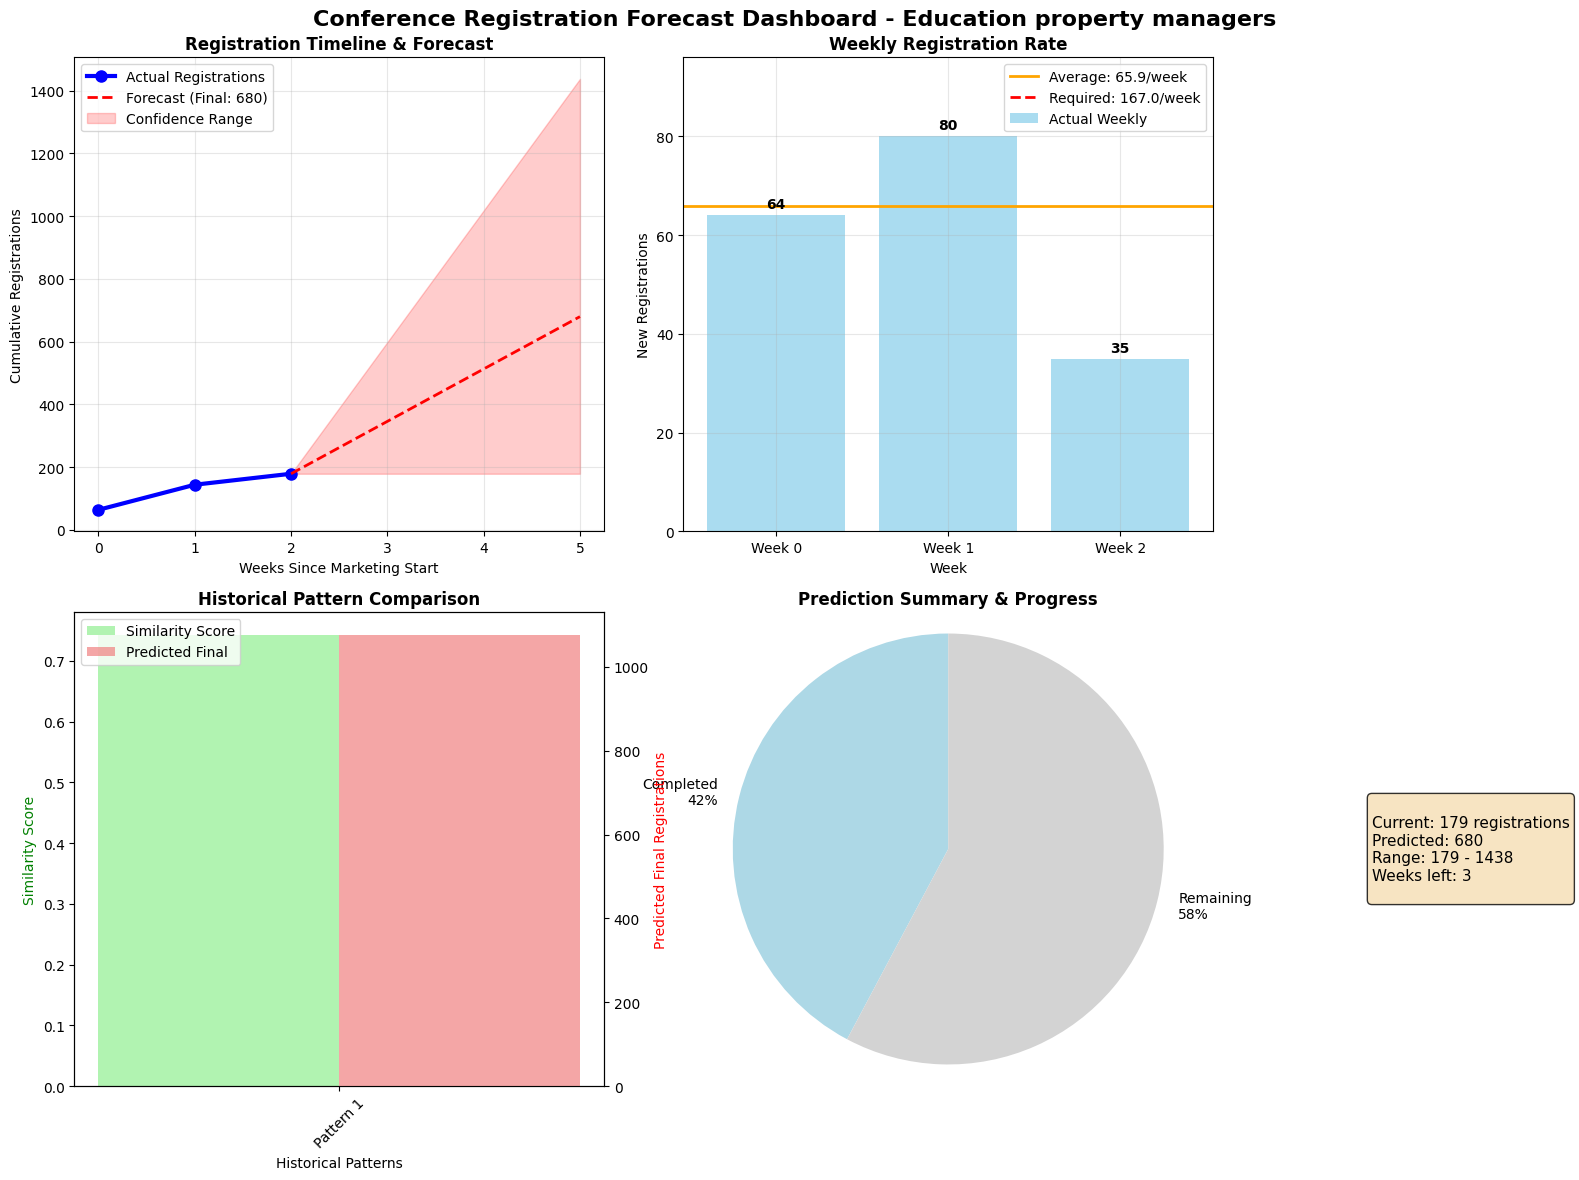


WEEKLY REGISTRATION VERIFICATION
Week-by-week breakdown (as displayed in graph):
  Week 0: 64 new registrations (Total: 64)
  Week 1: 80 new registrations (Total: 144)
  Week 2: 35 new registrations (Total: 179)


In [8]:
# =============================================================================
# VISUALIZATION DASHBOARD
# =============================================================================

def create_comprehensive_dashboard(current_data: Dict, predictions: Dict, matching_patterns: List[Dict], 
                                 date_info: Dict, user_config: Dict):
    """
    Create a comprehensive visualization dashboard.
    """
    if 'error' in current_data or 'error' in predictions:
        print("Cannot create dashboard due to data errors")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Conference Registration Forecast Dashboard - {user_config["target_audience"]}', 
                 fontsize=16, fontweight='bold')
    
    # Panel 1: Current vs. Predicted Timeline
    ax1.set_title('Registration Timeline & Forecast', fontweight='bold')
    
    current_weekly = current_data['weekly_data']
    weeks_elapsed = date_info['weeks_elapsed']
    weeks_remaining = date_info['weeks_remaining']
    total_weeks = weeks_elapsed + weeks_remaining
    
    # Current data
    if len(current_weekly) > 0:
        ax1.plot(current_weekly['Week'], current_weekly['CumulativeRegistrations'], 
                'o-', color='blue', linewidth=3, markersize=8, label='Actual Registrations')
    
    # Prediction line
    if weeks_remaining > 0:
        future_weeks = np.arange(weeks_elapsed, total_weeks + 1)
        current_total = predictions['current_total']
        final_prediction = predictions['ensemble_prediction']
        
        # Linear interpolation for forecast line
        future_values = np.linspace(current_total, final_prediction, len(future_weeks))
        ax1.plot(future_weeks, future_values, '--', color='red', linewidth=2, 
                label=f'Forecast (Final: {final_prediction:.0f})')
        
        # Confidence band
        low_values = np.linspace(current_total, predictions['low_estimate'], len(future_weeks))
        high_values = np.linspace(current_total, predictions['high_estimate'], len(future_weeks))
        ax1.fill_between(future_weeks, low_values, high_values, alpha=0.2, color='red', 
                        label='Confidence Range')
    
    ax1.set_xlabel('Weeks Since Marketing Start')
    ax1.set_ylabel('Cumulative Registrations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Weekly Registration Rate - FIXED DATA DISPLAY
    ax2.set_title('Weekly Registration Rate', fontweight='bold')
    
    if len(current_weekly) > 0:
        # Ensure we're displaying the actual registration data correctly
        weeks = current_weekly['Week'].values
        registrations = current_weekly['Registrations'].values
        
        # Create bars with proper data mapping
        bars = ax2.bar(weeks, registrations, color='skyblue', alpha=0.7, label='Actual Weekly')
        
        # Add value labels on top of bars for clarity
        for i, (week, reg) in enumerate(zip(weeks, registrations)):
            ax2.text(week, reg + max(registrations) * 0.01, f'{int(reg)}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Average line
        avg_rate = current_data['avg_weekly_rate']
        ax2.axhline(y=avg_rate, color='orange', linestyle='-', linewidth=2, 
                   label=f'Average: {avg_rate:.1f}/week')
        
        # Required future rate
        if weeks_remaining > 0:
            required_rate = predictions['additional_registrations_needed'] / weeks_remaining
            ax2.axhline(y=required_rate, color='red', linestyle='--', linewidth=2, 
                       label=f'Required: {required_rate:.1f}/week')
        
        # Set y-axis to start from 0 and show proper scale
        ax2.set_ylim(0, max(max(registrations) * 1.2, avg_rate * 1.2))
        
        # Ensure x-axis shows all weeks properly
        ax2.set_xticks(weeks)
        ax2.set_xticklabels([f'Week {int(w)}' for w in weeks])
    
    ax2.set_xlabel('Week')
    ax2.set_ylabel('New Registrations')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Pattern Matching Results
    ax3.set_title('Historical Pattern Comparison', fontweight='bold')
    
    if matching_patterns:
        pattern_names = [f"Pattern {i+1}" for i in range(min(5, len(matching_patterns)))]
        similarities = [p['similarity_score'] for p in matching_patterns[:5]]
        predictions_vals = [p['predicted_final'] for p in matching_patterns[:5]]
        
        # Create twin axis for predictions
        ax3_twin = ax3.twinx()
        
        bars1 = ax3.bar([i-0.2 for i in range(len(pattern_names))], similarities, 
                       width=0.4, color='lightgreen', alpha=0.7, label='Similarity Score')
        bars2 = ax3_twin.bar([i+0.2 for i in range(len(pattern_names))], predictions_vals, 
                           width=0.4, color='lightcoral', alpha=0.7, label='Predicted Final')
        
        ax3.set_xlabel('Historical Patterns')
        ax3.set_ylabel('Similarity Score', color='green')
        ax3_twin.set_ylabel('Predicted Final Registrations', color='red')
        ax3.set_xticks(range(len(pattern_names)))
        ax3.set_xticklabels(pattern_names, rotation=45)
        
        # Combine legends
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        ax3.text(0.5, 0.5, 'No matching patterns found', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=14)
        ax3.set_xticks([])
        ax3.set_yticks([])
    
    # Panel 4: Prediction Summary
    ax4.set_title('Prediction Summary & Progress', fontweight='bold')
    
    # Progress pie chart
    completion_pct = date_info['completion_percentage']
    remaining_pct = 100 - completion_pct
    
    pie_data = [completion_pct, remaining_pct]
    pie_labels = [f'Completed\n{completion_pct:.0f}%', f'Remaining\n{remaining_pct:.0f}%']
    colors = ['lightblue', 'lightgray']
    
    ax4.pie(pie_data, labels=pie_labels, colors=colors, autopct='', startangle=90)
    ax4.axis('equal')
    
    # Add text summary
    summary_text = f"""
Current: {predictions['current_total']} registrations
Predicted: {predictions['ensemble_prediction']:.0f}
Range: {predictions['low_estimate']:.0f} - {predictions['high_estimate']:.0f}
Weeks left: {weeks_remaining}
"""
    ax4.text(1.3, 0.5, summary_text, transform=ax4.transAxes, fontsize=11, 
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed weekly breakdown for verification
    print("\n" + "=" * 50)
    print("WEEKLY REGISTRATION VERIFICATION")
    print("=" * 50)
    print("Week-by-week breakdown (as displayed in graph):")
    for _, row in current_weekly.iterrows():
        week = int(row['Week'])
        registrations = int(row['Registrations'])
        cumulative = int(row['CumulativeRegistrations'])
        print(f"  Week {week}: {registrations} new registrations (Total: {cumulative})")
    print("=" * 50)

# Create comprehensive dashboard
create_comprehensive_dashboard(current_analysis, predictions, matching_patterns, date_info, user_config)

In [9]:
# =============================================================================
# RISK ASSESSMENT AND RECOMMENDATIONS
# =============================================================================

def generate_risk_assessment(current_data: Dict, predictions: Dict, date_info: Dict) -> Dict:
    """
    Generate risk assessment and actionable recommendations.
    """
    if 'error' in current_data or 'error' in predictions:
        return {'error': 'Cannot assess risk due to data errors'}
    
    current_total = predictions['current_total']
    predicted_final = predictions['ensemble_prediction']
    low_estimate = predictions['low_estimate']
    high_estimate = predictions['high_estimate']
    
    weeks_remaining = date_info['weeks_remaining']
    completion_pct = date_info['completion_percentage']
    
    assessment = {
        'risk_level': 'LOW',
        'confidence': 'HIGH',
        'risks': [],
        'opportunities': [],
        'recommendations': []
    }
    
    # Risk factors
    uncertainty_ratio = (high_estimate - low_estimate) / predicted_final
    
    if uncertainty_ratio > 0.4:
        assessment['confidence'] = 'LOW'
        assessment['risks'].append('High prediction uncertainty - wide confidence range')
    elif uncertainty_ratio > 0.2:
        assessment['confidence'] = 'MEDIUM'
        assessment['risks'].append('Moderate prediction uncertainty')
    
    # Timeline risks
    if weeks_remaining < 2:
        assessment['risk_level'] = 'HIGH'
        assessment['risks'].append('Very limited time remaining for adjustments')
    elif weeks_remaining < 4:
        assessment['risk_level'] = 'MEDIUM'
        assessment['risks'].append('Limited time for major marketing changes')
    
    # Pace analysis
    if weeks_remaining > 0:
        required_rate = predictions['additional_registrations_needed'] / weeks_remaining
        current_rate = current_data['recent_velocity']
        
        pace_ratio = required_rate / max(current_rate, 0.1)
        
        if pace_ratio > 2.0:
            assessment['risk_level'] = 'HIGH'
            assessment['risks'].append(f'Need to increase registration pace by {((pace_ratio - 1) * 100):.0f}%')
            assessment['recommendations'].append('Consider intensive marketing campaign or incentives')
        elif pace_ratio > 1.3:
            if assessment['risk_level'] == 'LOW':
                assessment['risk_level'] = 'MEDIUM'
            assessment['risks'].append(f'Need to increase registration pace by {((pace_ratio - 1) * 100):.0f}%')
            assessment['recommendations'].append('Consider boosting marketing efforts')
        elif pace_ratio < 0.7:
            assessment['opportunities'].append('Current pace is ahead of schedule - good position')
    
    # Data quality assessment
    if len(current_data['weekly_data']) < 3:
        assessment['confidence'] = 'LOW'
        assessment['risks'].append('Limited historical data for reliable prediction')
    
    # General recommendations
    if completion_pct < 25:
        assessment['recommendations'].append('Early stage - monitor closely and adjust marketing strategy')
    elif completion_pct < 75:
        assessment['recommendations'].append('Mid-campaign - optimize based on current performance')
    else:
        assessment['recommendations'].append('Late stage - focus on final push and conversion optimization')
    
    if uncertainty_ratio > 0.3:
        assessment['recommendations'].append('High uncertainty - plan for both optimistic and conservative scenarios')
    
    # Opportunities
    if predicted_final > current_total * 1.5:
        assessment['opportunities'].append('Strong growth potential - consider expanding capacity if needed')
    
    if len(assessment['risks']) == 0:
        assessment['opportunities'].append('All indicators positive - maintain current strategy')
    
    return assessment

# Generate risk assessment
risk_assessment = generate_risk_assessment(current_analysis, predictions, date_info)

if 'error' not in risk_assessment:
    print("\n" + "=" * 60)
    print("RISK ASSESSMENT & RECOMMENDATIONS")
    print("=" * 60)
    
    # Risk level indicator
    risk_colors = {'LOW': '🟢', 'MEDIUM': '🟡', 'HIGH': '🔴'}
    confidence_colors = {'HIGH': '🟢', 'MEDIUM': '🟡', 'LOW': '🔴'}
    
    print(f"\nOverall Assessment:")
    print(f"  Risk Level: {risk_colors.get(risk_assessment['risk_level'], '')} {risk_assessment['risk_level']}")
    print(f"  Confidence: {confidence_colors.get(risk_assessment['confidence'], '')} {risk_assessment['confidence']}")
    
    if risk_assessment['risks']:
        print(f"\n⚠️ Risk Factors:")
        for risk in risk_assessment['risks']:
            print(f"  • {risk}")
    
    if risk_assessment['opportunities']:
        print(f"\n✅ Opportunities:")
        for opportunity in risk_assessment['opportunities']:
            print(f"  • {opportunity}")
    
    if risk_assessment['recommendations']:
        print(f"\n💡 Recommendations:")
        for recommendation in risk_assessment['recommendations']:
            print(f"  • {recommendation}")
    
    print(f"\n📊 Quick Summary:")
    print(f"  • Current: {predictions['current_total']} registrations")
    print(f"  • Expected: {predictions['ensemble_prediction']:.0f} registrations")
    print(f"  • Range: {predictions['low_estimate']:.0f} - {predictions['high_estimate']:.0f}")
    print(f"  • Time remaining: {date_info['weeks_remaining']} weeks")
    print(f"  • Campaign: {date_info['completion_percentage']:.0f}% complete")
    
else:
    print(f"\nRisk Assessment Error: {risk_assessment['error']}")


RISK ASSESSMENT & RECOMMENDATIONS

Overall Assessment:
  Risk Level: 🔴 HIGH
  Confidence: 🔴 LOW

⚠️ Risk Factors:
  • High prediction uncertainty - wide confidence range
  • Limited time for major marketing changes
  • Need to increase registration pace by 190%

✅ Opportunities:
  • Strong growth potential - consider expanding capacity if needed

💡 Recommendations:
  • Consider intensive marketing campaign or incentives
  • Mid-campaign - optimize based on current performance
  • High uncertainty - plan for both optimistic and conservative scenarios

📊 Quick Summary:
  • Current: 179 registrations
  • Expected: 680 registrations
  • Range: 179 - 1438
  • Time remaining: 3 weeks
  • Campaign: 42% complete


## How to Use This System

### Quick Start:
1. **Update User Inputs**: Modify the values in the "USER INPUT INTERFACE" cell:
   - `selected_audience_idx`: Choose target audience (1-4) or 5 for "all"
   - `event_date`: Set your event date (DD/MM/YYYY format)
   - `marketing_start_date`: Set when marketing began

2. **Update Current Data**: Replace `sample_data.csv` with your latest registration data

3. **Run All Cells**: Execute the notebook to get real-time predictions

### Key Features:
- **Real-time Updates**: Easy to re-run with fresh registration data
- **Multiple Prediction Methods**: Pattern matching, velocity analysis, curve fitting
- **Confidence Intervals**: Low and high estimates for planning
- **Risk Assessment**: Automated alerts and recommendations
- **Visual Dashboard**: Comprehensive charts and progress tracking

### Understanding the Output:
- **Most Likely Total**: Best estimate based on ensemble of methods
- **Low/High Estimates**: Conservative and optimistic scenarios
- **Confidence Range**: Indicates prediction reliability
- **Risk Level**: GREEN (low risk), YELLOW (medium), RED (high risk)
- **Recommendations**: Actionable steps based on current situation

This system provides practical, data-driven insights for conference planning and marketing optimization.